<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/Face_age_estimation_CNN_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input

In [3]:
# # Define a function to preprocess images
# def preprocess_image(image_path):
#     image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (224, 224))
#     image = image.astype('float32') / 255.0
#     # Add channel dimension for grayscale images
#     image = np.expand_dims(image, axis=-1)
#     return image

In [4]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define age group conversion
def age_to_group(age):
    return age // 5

Image preprocessing

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
image_paths = []
age_labels = []

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    image_path = os.path.join(image_dir, filename)
    image_paths.append(image_path)
    age_labels.append(age)

images = np.array([preprocess_image(img_path) for img_path in image_paths])
age_groups = np.array([age_to_group(age) for age in age_labels])

In [8]:
print(f'number of images : {len(images)}')

number of images : 9931


In [9]:
# Function to convert age group index to interval string
def age_group_to_interval(group_index):
    start = group_index * 3
    end = (group_index + 1) * 3
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,15-18
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,21-24
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,21-24
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,30-33
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,12-15
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,21-24
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,33-36
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,30-33
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,21-24
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,21-24


Exploratory data analysis

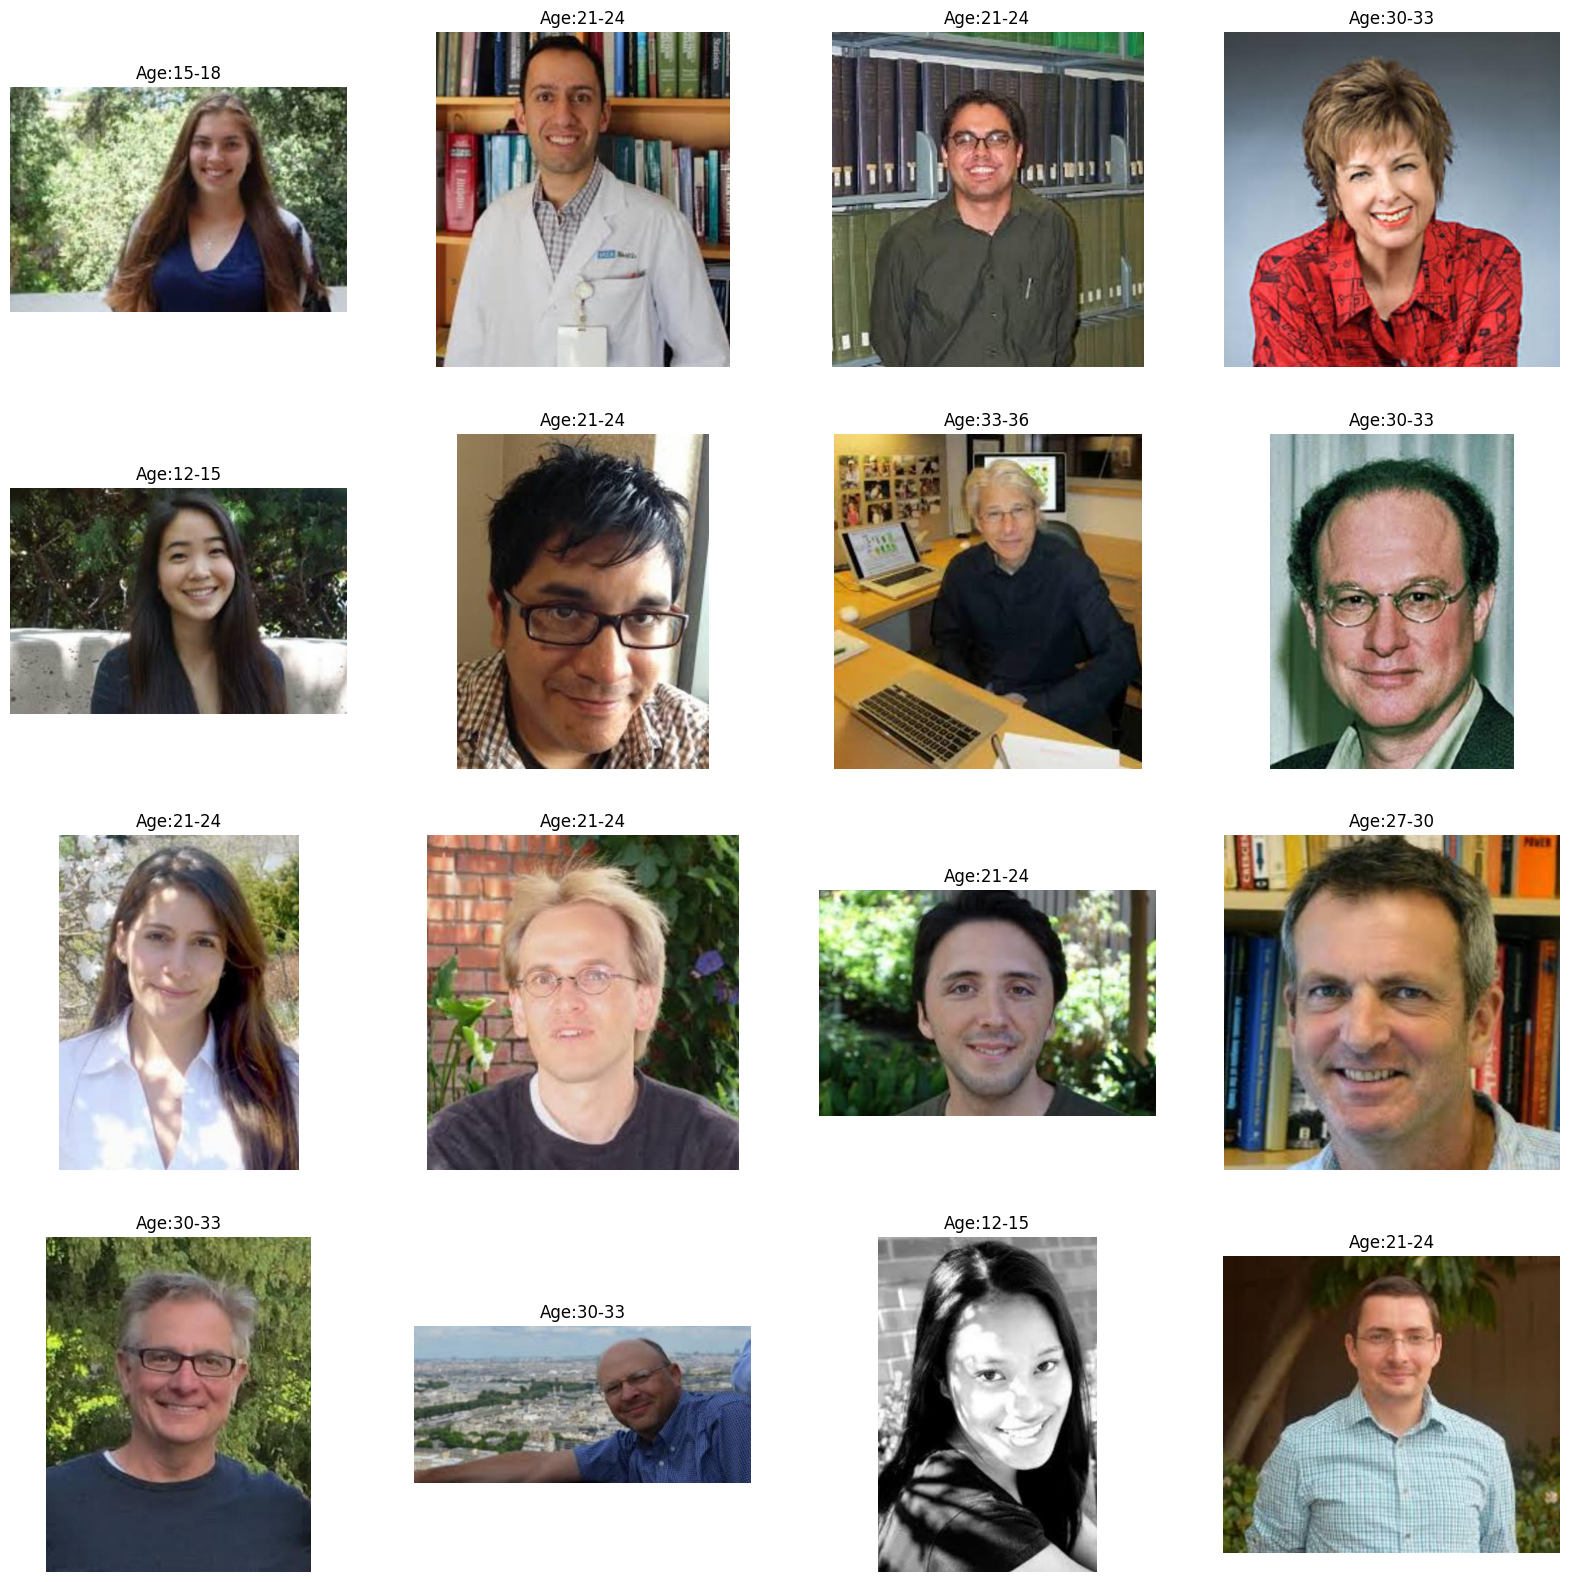

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

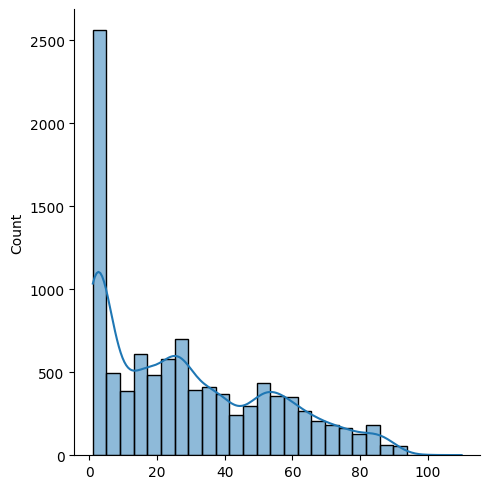

In [12]:
#age distribution
sns.displot(data=age_labels,kde=True)

In [13]:
# Example: Convert age groups to categorical if not already
age_group_indices = [age // 3 for age in age_groups]  # Convert ages to 3-year interval indices
num_classes = np.max(age_groups) + 1
age_groups_categorical = to_categorical(age_groups, num_classes)
print(num_classes)

23


Split data

In [14]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_groups_categorical, test_size=0.2, random_state=42)


Compile the model

In [15]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(num_classes, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


SetUp Callbacks

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_age_group_model.h5', save_best_only=True, monitor='val_loss')


Train the model

In [17]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 2.5220 - accuracy: 0.2714

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 80s 217ms/step - loss: 2.5220 - accuracy: 0.2714 - val_loss: 2.8968 - val_accuracy: 0.1064
Epoch 2/50
199/199 [==============================] - 36s 179ms/step - loss: 2.1231 - accuracy: 0.3273 - val_loss: 2.4376 - val_accuracy: 0.3323
Epoch 3/50
199/199 [==============================] - 36s 179ms/step - loss: 1.8516 - accuracy: 0.3844 - val_loss: 2.0860 - val_accuracy: 0.3216
Epoch 4/50
199/199 [==============================] - 34s 173ms/step - loss: 1.7190 - accuracy: 0.4061 - val_loss: 2.5697 - val_accuracy: 0.1938
Epoch 5/50
199/199 [==============================] - 35s 174ms/step - loss: 1.5949 - accuracy: 0.4371 - val_loss: 2.9274 - val_accuracy: 0.3014
Epoch 6/50
199/199 [==============================] - 35s 174ms/step - loss: 1.4877 - accuracy: 0.4680 - val_loss: 2.4367 - val_accuracy: 0.3298
Epoch 7/50
199/199 [==============================] - 35s 175ms/step - loss: 1.3719 - accuracy: 0.4960 - val_loss: 3.0275 - val_accuracy: 0.2

Load best model and evaluate

In [18]:
# Load the best model
model.load_weights('best_age_group_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


63/63 [==============================] - 4s 60ms/step - loss: 1.9755 - accuracy: 0.3770
Test Accuracy: 37.70%


In [27]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

63/63 [==============================] - 4s 48ms/step


In [28]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       485
           1       0.25      0.22      0.23       134
           2       0.19      0.36      0.25       105
           3       0.26      0.37      0.30       145
           4       0.40      0.07      0.12       146
           5       0.25      0.27      0.26       175
           6       0.25      0.01      0.02        90
           7       0.20      0.22      0.21       103
           8       0.20      0.03      0.05        64
           9       0.19      0.38      0.25        76
          10       0.22      0.08      0.12       120
          11       0.14      0.06      0.08        70
          12       0.17      0.21      0.19        70
          13       0.15      0.12      0.13        69
          14       0.00      0.00      0.00        29
          15       0.09      0.11      0.10        35
          16       0.12      0.41      0.19        17
          17       0.31    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.38
Precision: 0.36
Recall: 0.38
F1-score: 0.34


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
